# Clasificador de reseñas

- **Joan Pedro Bruxola**
- **Julio García Bustos**
- **Marcos Rosique Martínez**
- **Mario Soto Ramos**

Primero importamos todas las librerías importantes

In [1]:
import numpy as np
import pandas as pd
import requests
import re
import os
import zipfile

from collections import Counter
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import time
from langdetect import detect, LangDetectException
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from spacy.lang.en.stop_words import STOP_WORDS
from sentence_transformers import SentenceTransformer
#from xgboost import XGBClassifier

from transformers import pipeline

c:\Users\Juanjo\.conda\envs\spacy-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Extracción de URLs

### URLs de las películas

In [ ]:
# Páginas específicas a scrapear
paginas_objetivo = [1, 2, 3, 365, 366]

# Número de películas a extraer de cada página
n_por_pagina = 24

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Cabecera para evitar bloqueo
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

# Lista para almacenar todos los enlaces
link_list = []

# Iterar por las páginas deseadas
for page in paginas_objetivo:
    print(f"\nAccediendo a página {page}...")

    params = {
        "releaseYearMin": 1990,
        "releaseYearMax": 2014,
        "page": page
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error al acceder a la página {page}.")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    movie_links = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")

    if not movie_links:
        print("No se encontraron películas en esta página.")
        continue

    # Limitar a las primeras `n_por_pagina` películas
    for idx, link in enumerate(movie_links[:n_por_pagina]):
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            link_list.append(full_url)
            print(f"[Pág. {page}] Película {idx+1}: {full_url}")

    time.sleep(1)  # Pausa entre páginas

# Resultados finales
print(f"\nTotal de enlaces obtenidos: {len(link_list)}")


Accediendo a página 1...
[Pág. 1] Película 1: https://www.metacritic.com/movie/dekalog-1988/
[Pág. 1] Película 2: https://www.metacritic.com/movie/boyhood/
[Pág. 1] Película 3: https://www.metacritic.com/movie/three-colors-red/
[Pág. 1] Película 4: https://www.metacritic.com/movie/the-leopard-re-release/
[Pág. 1] Película 5: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/
[Pág. 1] Película 6: https://www.metacritic.com/movie/fanny-and-alexander-re-release/
[Pág. 1] Película 7: https://www.metacritic.com/movie/army-of-shadows/
[Pág. 1] Película 8: https://www.metacritic.com/movie/pepe-le-moko-re-release/
[Pág. 1] Película 9: https://www.metacritic.com/movie/pans-labyrinth/
[Pág. 1] Película 10: https://www.metacritic.com/movie/hoop-dreams/
[Pág. 1] Película 11: https://www.metacritic.com/movie/metropolis-re-release/
[Pág. 1] Película 12: https://www.metacritic.com/movie/rififi-re-release/
[Pág. 1] Película 13: https://www.metacritic.com/movie/4-months-3-weeks-and-2-days

### URLs de las reseñas

In [ ]:
# Definir los filtros y las listas
filters = ['Mixed%20Reviews', 'Negative%20Reviews']

# Lista para almacenar los enlaces
review_links = [f"{link}user-reviews/?filter={filter_type}" for filter_type in filters for link in link_list]
print(f"Tamaño de review_links: {len(review_links)}")

Tamaño de review_links: 240


## Extracción y almacenamiento de reseñas

In [ ]:
def get_user_reviews_selenium(movie_url, max_pages=1, n_res=50):
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  # Solo una página por URL
        url = f"{movie_url}&page={page + 1}"  # Se añade la página actual a la URL
        driver.get(url)
        time.sleep(2)  # Espera a que cargue JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  # Añadimos la URL de la película
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= n_res:  # Si ya tenemos n reseñas, salimos del bucle
            break

    driver.quit()
    return all_reviews


# Lista para almacenar todas las reseñas
all_reviews_data = []

# Extraer n reseñas para cada enlace en review_links
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url, n_res=50)

    # Almacenar las reseñas en la lista
    for review in reviews:
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame de pandas
df_reviews = pd.DataFrame(all_reviews_data)

# Mostrar las primeras filas del DataFrame
print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/dekalog-1988/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/boyhood/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/three-colors-red/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/the-leopard-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/fanny-and-alexander-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/army-of-shadows/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pepe-le-moko-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pans-labyrinth/user-reviews/?filter=Mi

In [ ]:
# Guardar el DataFrame en un archivo CSV
df_reviews.to_csv("./data/reviews_finales_bad_mixed_only.csv", index=True)

## Preprocesamiento

In [2]:
# Cargar los dos CSV
df1 = pd.read_csv("./data/reviews_finales.csv")
df2 = pd.read_csv("./data/reviews_finales_2.csv")
df3 = pd.read_csv("./data/reviews_finales_3.csv")
df4 = pd.read_csv("./data/reviews_finales_bad_mixed_only.csv")

# Concatenar y resetear índice para evitar duplicados o índices desordenados
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Eliminamos la columna Unnamed: 0
df = df.drop('Unnamed: 0', axis=1)
# Verifica el resultado
print(df.shape)

(9953, 5)


In [3]:
df.head()

,movie_url,username,date,score,review
0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [4]:
# Devuelve un booleano para cada fila indicando si es duplicada (excepto la primera aparición)
duplicated_rows = df.duplicated()

# Mostrar filas duplicadas
print(df[duplicated_rows])

Empty DataFrame
Columns: [movie_url, username, date, score, review]
Index: []


In [5]:
# Aplicar la extracción y transformación del nombre de la película a la columna "movie_url"
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())

# Renombrar la columna "movie_url" a "movie"
df = df.rename(columns={"movie_url": "movie"})

df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [6]:
df = df[~df['review'].isna()]

In [7]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas donde la columna 'review' contiene "SPOILER ALERT" y crear la columna 'sentiment' basada en la columna 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

# Filtrar el DataFrame para quedarse solo con las filas donde el idioma es 'en'
df = df[df['language'] == 'en']

df = df.drop('language', axis = 1)

df.head(5)

,movie,username,date,score,review
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [8]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))

df.head(5)

,movie,username,date,score,review,sentiment
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [9]:
df.shape

(8703, 6)

Instalación del modelo de spaCy

Para instalar el modelo `en_core_web_md` de **spaCy**, ejecuta el siguiente comando en tu **Anaconda Prompt** o **Terminal**:

```bash
python -m spacy download en_core_web_md


In [8]:
!python -m spacy download en_core_web_md


     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
      --------------------------------------- 0.8/33.5 MB 4.2 MB/s eta 0:00:08
     - -------------------------------------- 1.6/33.5 MB 4.4 MB/s eta 0:00:08
     --- ------------------------------------ 2.6/33.5 MB 4.2 MB/s eta 0:00:08
     ---- ----------------------------------- 3.4/33.5 MB 4.2 MB/s eta 0:00:08
     ----- ---------------------------------- 4.5/33.5 MB 4.1 MB/s eta 0:00:08
     ------ --------------------------------- 5.2/33.5 MB 4.1 MB/s eta 0:00:07
     ------- -------------------------------- 6.0/33.5 MB 4.1 MB/s eta 0:00:07
     -------- ------------------------------- 7.1/33.5 MB 4.2 MB/s eta 0:00:07
     --------- ------------------------------ 8.1/33.5 MB 4.2 MB/s eta 0:00:07
     ---------- ----------------------------- 8.9/33.5 MB 4.2 MB/s eta 0:00:06
     ----------- ---------------------------- 10.0/33.5 MB 4.3 MB/s eta 0:00:06
     ------------ --------------------------- 10.7/33.5 MB

In [10]:
nlp = spacy.load('en_core_web_md')

In [ ]:
print(STOP_WORDS)

{'could', 'seemed', "'s", 'as', 'ours', 'name', 'thereupon', 'become', 'across', 'hers', 'from', 'such', 'should', 'some', 'she', 'against', 'meanwhile', 'no', 'between', 'during', 'about', 'often', 'full', "'m", 'these', 'thus', 'by', 'whereafter', 'towards', 'otherwise', 'few', 'hereupon', 'via', 'why', '‘ll', 'regarding', 'make', 'does', 'of', 'had', 'we', 'everything', 'to', 'due', 'per', 'always', 'though', 'however', 'side', 'once', 'less', 'whither', 'sometime', 'rather', 'how', 'whereby', 'back', 'both', 'down', 'himself', 'them', 'nowhere', 'just', 'would', 'else', "'ve", 'whom', 'made', 'ca', 'somehow', 'without', 'i', 'an', 'last', 'six', 'you', 'did', 'the', 'amount', 'sometimes', 'anyway', 'wherever', 'out', 'must', 'what', 'can', 'in', 'until', 'show', 'am', 'everywhere', 'this', 'do', '’m', 'thru', 'our', 'next', 'will', 'your', 'although', 'latterly', 'top', 'herself', 'when', 'together', 're', 'before', 'moreover', 'at', 'a', 'empty', 'whoever', 'somewhere', 'his', 'yo

Podemos calcular un porcentaje de stopwords para cada clase, para ver directamente la influencia de ellos en el texto.

In [12]:
# función para calcular el porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

# Función para limpiar, tokenizar y lematizar
def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

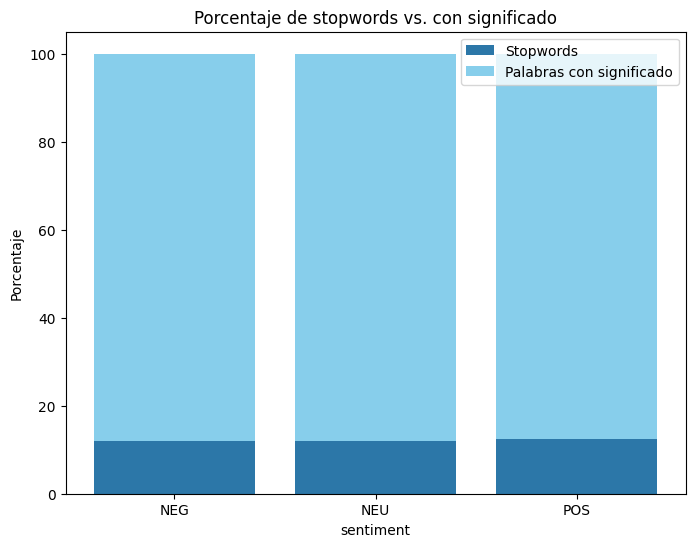

In [13]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

Podemos ver como el porcentaje de stopwords es de alrededor del 15%

In [14]:
# Definir el patrón para los caracteres especiales
pat = '[{}]'.format(re.escape(string.punctuation))

# Definir la función para normalizar, lematizar y eliminar puntuación
def normalize_document_remove_punct(doc, lemmatize=True):
    doc = re.sub(r'\d+', '', doc)
    tokens = nlp(doc)

    if lemmatize:
        filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())
                           for t in tokens
                           if not t.is_stop
                           and not t.is_punct
                           and not t.is_space]
    else:
        filtered_tokens = [re.sub(pat, ' ', t.text.lower())
                           for t in tokens
                           if not t.is_stop
                           and not t.is_punct
                           and not t.is_space]

    doc = ' '.join(filtered_tokens)
    return doc

# Aplicar la función a cada elemento de la columna 'contenido' tanto en treino como en test
df['review_lem'] = df['review'].apply(lambda x: normalize_document_remove_punct(x, lemmatize=True))

df['review_no_lem'] = df['review'].apply(lambda x: normalize_document_remove_punct(x, lemmatize=False))

In [15]:
df = df[['movie', 'username', 'date', 'score', 'review', 'review_lem', 'review_no_lem', 'sentiment', 'stopword_percentage']]

df

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",refined production obvious weakness base ratio...,refined production obvious weaknesses based ra...,POS,13.333333
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313
...,...,...,...,...,...,...,...,...,...
9948,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,"You can make fun of it, laugh at it, and it is...",fun laugh excellent award garbage get razzie b...,fun laugh excellent awards garbage got razzie ...,NEG,15.264798
9949,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,Let's just say that Paris Hilton in a bikini i...,let paris hilton bikini bright spot movie bori...,let paris hilton bikini bright spot movie bori...,NEG,13.375796
9950,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,It's time for Paris Hilton to go back to Carls...,time paris hilton carls jr start make porno m...,time paris hilton carls jr start making porno...,NEG,10.765550
9951,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,"This film easily fits into the ""worst of all t...",film easily fit bad time category ah painful w...,film easily fits worst times category ah painf...,NEG,11.637931


## Exploratorio

Aplicamos una tokenización a los datos, para separar las palabras que tenemos en tokens para poder estudiarlo de manera clara y concisa.

In [17]:
def process_text_column(df, text_column, lemmatizer=None):
    df['tokens'] = df[text_column].apply(nlp)
    return df

In [19]:
process_text_column(df, "review_lem")

,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,tokens
0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000,"(absolutely, brilliant, film, character, deep,..."
3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647,"(feel, emotion, long, time, chiron, manifest, ..."
5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118,"(movie, masterpiece, deserve, oscar)"
6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",refined production obvious weakness base ratio...,refined production obvious weaknesses based ra...,POS,13.333333,"(refined, production, obvious, weakness, base,..."
7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313,"(decent, movie, story, , so, scoring, great,..."
...,...,...,...,...,...,...,...,...,...,...
9948,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,"You can make fun of it, laugh at it, and it is...",fun laugh excellent award garbage get razzie b...,fun laugh excellent awards garbage got razzie ...,NEG,15.264798,"(fun, laugh, excellent, award, garbage, get, r..."
9949,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,Let's just say that Paris Hilton in a bikini i...,let paris hilton bikini bright spot movie bori...,let paris hilton bikini bright spot movie bori...,NEG,13.375796,"(let, paris, hilton, bikini, bright, spot, mov..."
9950,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,It's time for Paris Hilton to go back to Carls...,time paris hilton carls jr start make porno m...,time paris hilton carls jr start making porno...,NEG,10.765550,"(time, paris, hilton, carls, jr, , start, mak..."
9951,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,"This film easily fits into the ""worst of all t...",film easily fit bad time category ah painful w...,film easily fits worst times category ah painf...,NEG,11.637931,"(film, easily, fit, bad, time, category, ah, p..."


Podemos graficar la distribución de longitud de textos para cada clase.

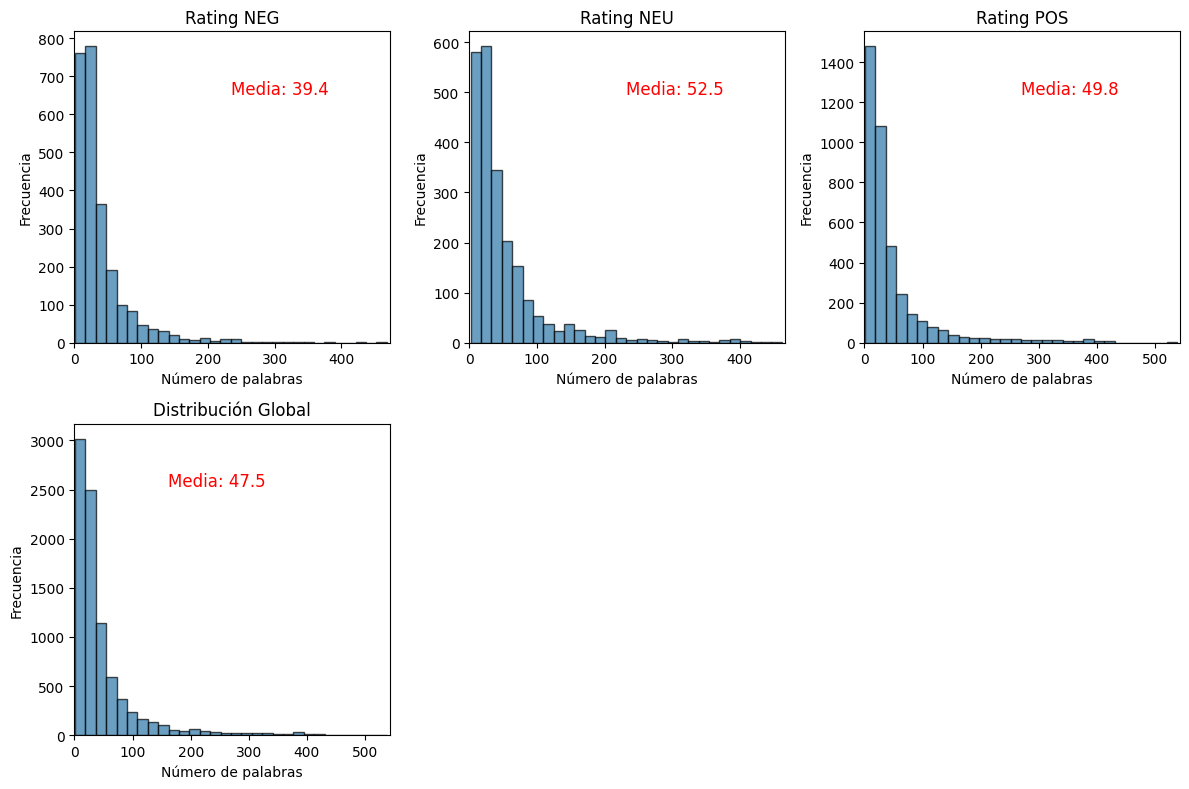

In [ ]:
def graficar_longitud_textos(df, text_column, rating_column):
    df['NP'] = df[text_column].apply(len)

    ratings = sorted(df[rating_column].unique())
    num_ratings = len(ratings)
    num_cols = min(3, num_ratings + 1)
    num_rows = (num_ratings + 1 + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = np.ravel(axes)

    for i, rating in enumerate(ratings):
        ax = axes[i]
        subset = df[df[rating_column] == rating]
        media_np = subset['NP'].mean()
        max_np = subset['NP'].max()

        ax.hist(subset['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
        ax.set_xlim(0, max_np + 5)  # Añadimos un margen para mejor visualización
        ax.set_xlabel('Número de palabras')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Rating {rating}')

        ax.text(max_np * 0.5, ax.get_ylim()[1] * 0.8, f'Media: {media_np:.1f}', fontsize=12, color='red')

    # Gráfico global al final
    global_ax = axes[num_ratings]
    media_global = df['NP'].mean()
    max_np_global = df['NP'].max()

    global_ax.hist(df['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
    global_ax.set_xlim(0, max_np_global + 5)
    global_ax.set_xlabel('Número de palabras')
    global_ax.set_ylabel('Frecuencia')
    global_ax.set_title('Distribución Global')
    global_ax.text(max_np_global * 0.3, global_ax.get_ylim()[1] * 0.8, f'Media: {media_global:.1f}', fontsize=12, color='red')

    # Eliminar subplots vacíos si hay
    for j in range(num_ratings + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_longitud_textos(df, 'tokens', 'sentiment')

Vemos como la mayoría de los textos tienen una longitud parecida para cada clase, la cuál refiere a unas 30-40 palabras por cada reseña, lo cuál nos va a ayudar a saber como se van a aplicar los word embeddings y los distintos modelos a los datos

Para ver las palabras más repetidas por vcada clase obtenemos los wordclouds

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suponemos que tienes un DataFrame `df` con columnas 'text' y 'category'

# 1. Vectorizador TF-IDF global
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['review_no_lem'])
words = vectorizer.get_feature_names_out()

# 2. Crear DataFrame TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=words)
tfidf_df['sentiment'] = df['sentiment'].values

# 3. Promedio TF-IDF por categoría
mean_tfidf_per_class = tfidf_df.groupby('sentiment').mean()

# 4. Calcular score diferencial
def differential_score(df_means):
    diff_scores = pd.DataFrame(index=df_means.index, columns=df_means.columns)
    for cat in df_means.index:
        for word in df_means.columns:
            val_in_cat = df_means.loc[cat, word]
            val_in_others = df_means.drop(cat)[word].max()
            diff_scores.loc[cat, word] = val_in_cat - val_in_others
    return diff_scores.fillna(0)

diff_scores = differential_score(mean_tfidf_per_class)

# 5. Obtener palabras exclusivas por categoría (top 100)
distinctive_words = {}
for cat in diff_scores.index:
    positive_scores = diff_scores.loc[cat][diff_scores.loc[cat] > 0]
    sorted_words_scores = positive_scores.sort_values(ascending=False)
    distinctive_words[cat] = sorted_words_scores

# 6. Crear wordclouds
plt.figure(figsize=(15, 8))

for i, (cat, scores) in enumerate(distinctive_words.items()):
    # Diccionario de palabras y su peso para la wordcloud
    word_freq = scores.to_dict()

    plt.subplot(1, len(distinctive_words), i + 1)
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud: {cat}')

plt.tight_layout()
plt.show()


In [ ]:
# Función para obtener n-gramas
def get_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Función para calcular y graficar bigramas y trigramas más comunes por clases
def plot_most_common_ngrams_by_class(df, text_column, class_column):
    # Crear subgráficos para bigramas
    num_classes = len(df[class_column].unique())
    ncols = 3  # Número de columnas de subgráficos
    nrows = (num_classes + ncols - 1) // ncols  # Calcular número de filas necesarias

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar bigramas
    for i, class_value in enumerate(df[class_column].unique()):

        # Asegúrate de que cada entrada sea una lista de strings
        # Asegúrate de que cada entrada sea una lista de strings
        df['tokens'] = df['tokens'].apply(lambda x: [t.text if hasattr(t, "text") else str(t) for t in x] if isinstance(x, list) else str(x).split())

        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular bigramas
        bigram_freq = Counter(get_ngrams(all_words, 2))

        # Obtener los 10 bigramas más comunes
        bigram_most_common = bigram_freq.most_common(10)

        # Bigramas
        bigrams, bigram_counts = zip(*bigram_most_common)
        axes[i].barh(bigrams, bigram_counts, color='#a9dfd0', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Bigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Bigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de bigramas
    plt.tight_layout()
    plt.show()

    # Crear subgráficos para trigramas
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar trigramas
    for i, class_value in enumerate(df[class_column].unique()):
        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular trigramas
        trigram_freq = Counter(get_ngrams(all_words, 3))

        # Obtener los 10 trigramas más comunes
        trigram_most_common = trigram_freq.most_common(10)

        # Trigramas
        trigrams, trigram_counts = zip(*trigram_most_common)
        axes[i].barh(trigrams, trigram_counts, color='#2C77A8', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Trigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Trigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de trigramas
    plt.tight_layout()
    plt.show()

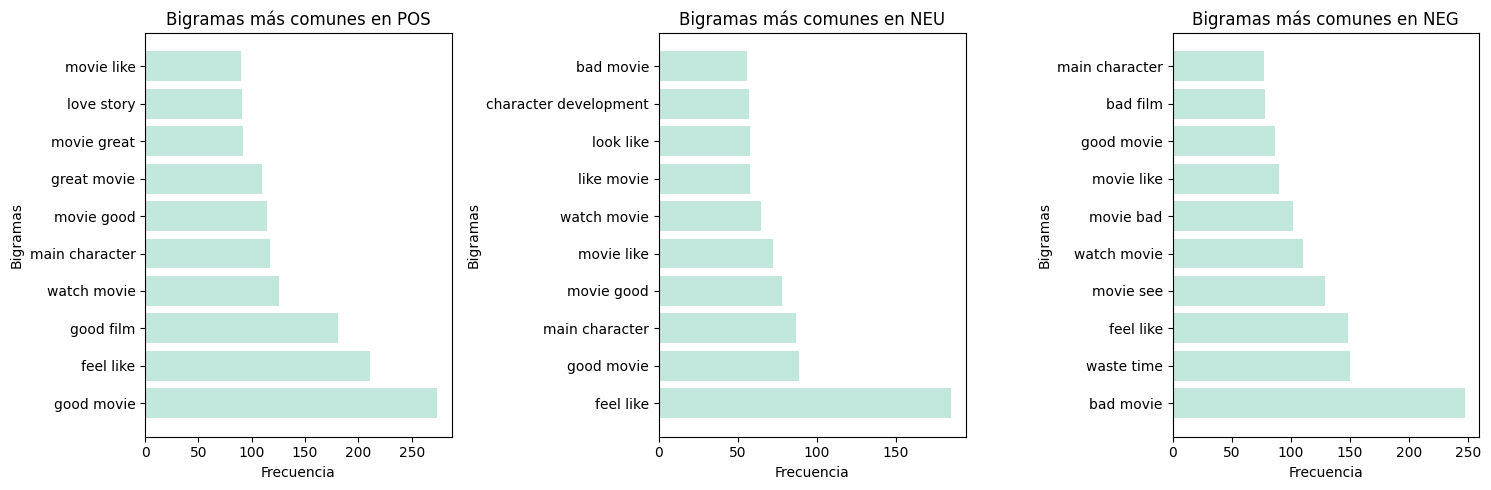

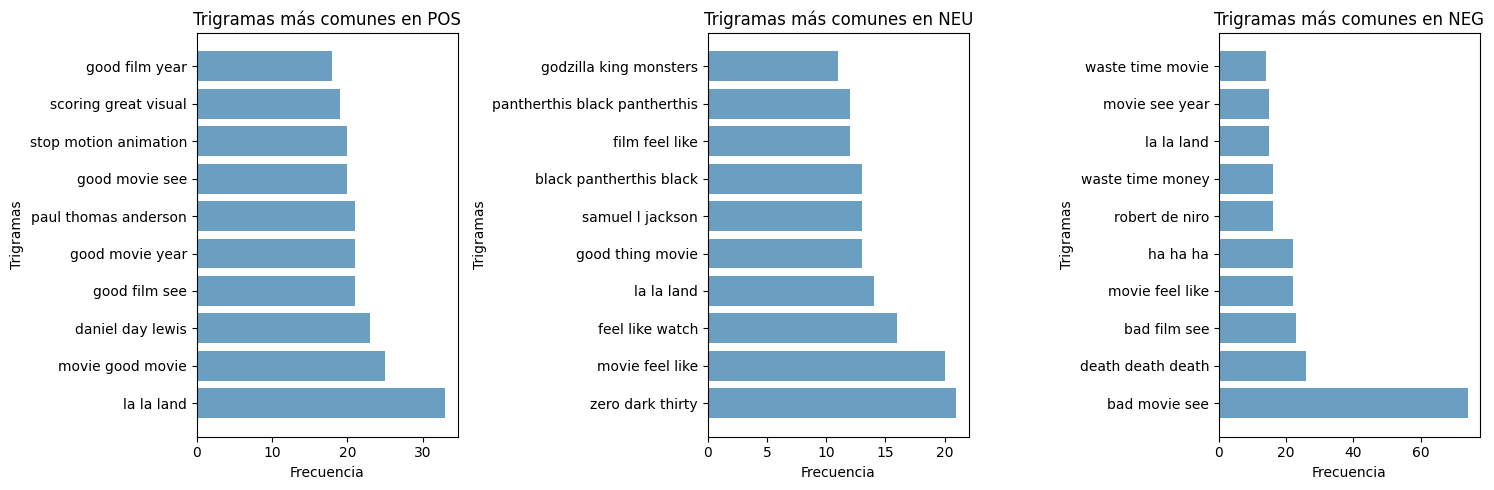

In [ ]:
plot_most_common_ngrams_by_class(df, "tokens", "sentiment")

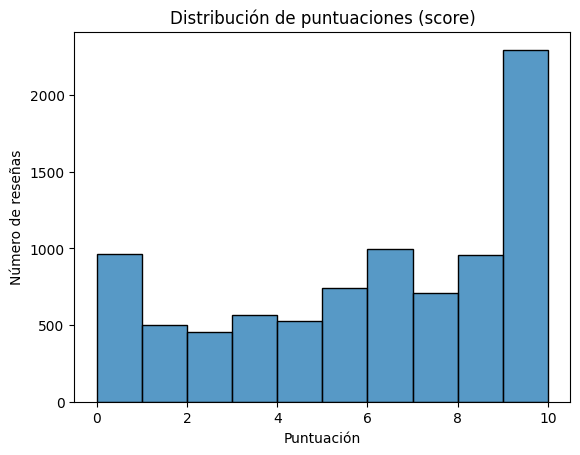

In [ ]:
sns.histplot(df['score'].astype(int), bins=10, kde=False)
plt.title('Distribución de puntuaciones (score)')
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()


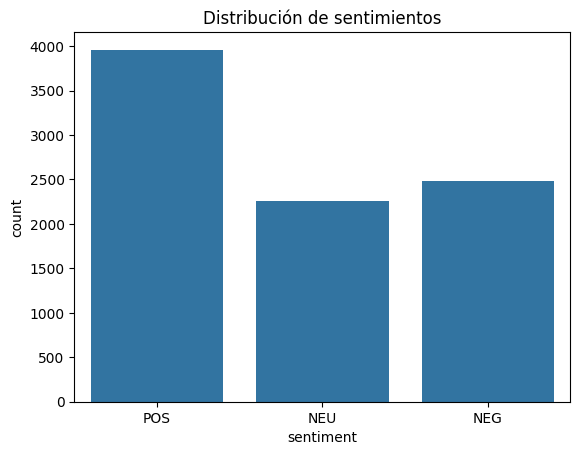

In [ ]:
sns.countplot(data=df, x='sentiment')
plt.title('Distribución de sentimientos')
plt.show()

## Extracción de características

### Separación en train y test

In [16]:
# Separar para clasificación
X_train, X_test, y_train, y_test = train_test_split(
    df['review_lem'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Separar para clasificación
X_train_no_lem, X_test_no_lem, y_train_no_lem, y_test_no_lem = train_test_split(
    df['review_no_lem'], df['sentiment'], test_size=0.2, random_state=42)

### Embeddings Sparse

#### TF-IDF

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['review_lem'])

print("Número total de palabras únicas:", len(vectorizer.vocabulary_))

Número total de palabras únicas: 22965


In [18]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

### Embeddings densos

##### GLOVE

In [20]:
glove_file_path = './models/glove.twitter.27B.50d.txt'

# Crear un diccionario vacío para almacenar los embeddings
glove_dict = {}

# Leer el archivo y cargar los embeddings en el diccionario
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Separar cada línea en la palabra y el vector
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = vector

# Verificar que se ha cargado correctamente el diccionario
print(f"Se han cargado {len(glove_dict)} palabras en el diccionario de GloVe.")

Se han cargado 1193514 palabras en el diccionario de GloVe.


In [21]:
# Función para convertir una reseña en un vector
def text_to_vector(text, glove_dict, dim=50):
    words = text.split()  # Dividir la reseña en palabras (suponiendo que ya están limpias)

    # Obtener el vector de cada palabra si está en el diccionario de GloVe
    valid_vectors = [glove_dict[word] for word in words if word in glove_dict]

    # Si hay palabras válidas, calcular la media de sus vectores
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        # Si no hay palabras válidas, devolver un vector de ceros
        return np.zeros(dim)

# Aplicar la función a cada reseña en el DataFrame
X_glove = np.vstack(df['review_lem'].apply(lambda x: text_to_vector(x, glove_dict)))

# Verificar la forma de los vectores resultantes
print(X_glove.shape)

(8703, 50)


In [22]:
# Para la tarea de clasificación de sentimiento
X_train_glove, X_test_glove, y_train, y_test = train_test_split(
    X_glove, df['sentiment'], test_size=0.2, random_state=42)

##### BERT

In [21]:
# Modelo multilingüe pequeño y rápido
model_bert = SentenceTransformer('all-mpnet-base-v2')

In [25]:
# Aplicar BERT a tus textos de test
X_train_bert = model_bert.encode(X_train_no_lem.tolist(), convert_to_numpy=True)
X_test_bert = model_bert.encode(X_test_no_lem.tolist(), convert_to_numpy=True)

## Modelos de clasificación (no preentrenados)

### Embedding Sparse 

#### TF-IDF + LR

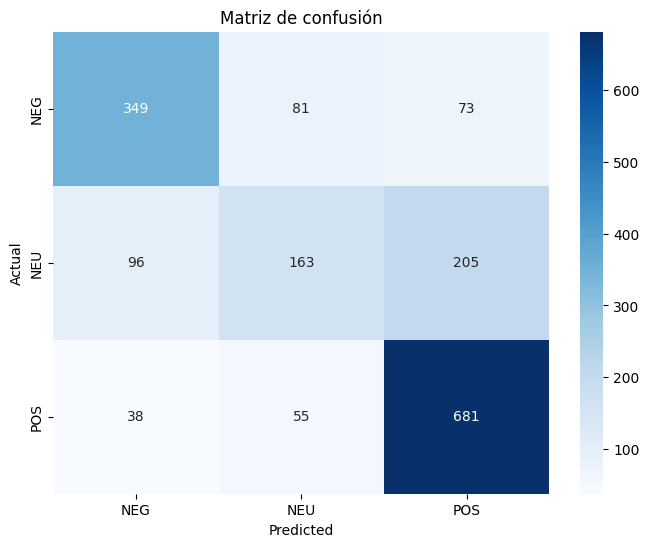

              precision    recall  f1-score   support

         NEG       0.72      0.69      0.71       503
         NEU       0.55      0.35      0.43       464
         POS       0.71      0.88      0.79       774

    accuracy                           0.69      1741
   macro avg       0.66      0.64      0.64      1741
weighted avg       0.67      0.69      0.67      1741



In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_vec, y_train_enc)
prediccion = modelLR.predict(X_test_vec)


# Calcular la matriz de confusión
cm = confusion_matrix(y_test_enc, prediccion)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
print(classification_report(y_test_enc, prediccion, target_names=le.classes_))

In [ ]:
# Crear un dataframe con las reseñas, verdaderas y predichas
errores_df = pd.DataFrame({
    'review': X_test.tolist(),
    'true_label': le.inverse_transform(y_train_enc),
    'predicted_label': le.inverse_transform(prediccion)
})

#### TF-IDF + Topic Modeling (LSA) + LR

In [ ]:
# 4. LSA - ajustar sobre el TF-IDF del train
lsa = TruncatedSVD(n_components=15, random_state=42)
X_train_topic = lsa.fit_transform(X_train_vec)
X_test_topic = lsa.transform(X_test_vec)

model = LogisticRegression(solver='liblinear')
model.fit(X_train_topic, y_train_enc)

# 6. Predicción y evaluación
y_pred = model.predict(X_test_topic)
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.66      0.60      0.63       503
         NEU       0.44      0.12      0.18       464
         POS       0.60      0.90      0.72       774

    accuracy                           0.61      1741
   macro avg       0.57      0.54      0.51      1741
weighted avg       0.58      0.61      0.55      1741



#### TF-IDF + Topic Modeling (LSA) + XGB

In [ ]:
# Codificar etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_train_enc = le.transform(y_train)

# Modelo XGBoost para clasificación multiclase
modelXGB = XGBClassifier(
    objective='multi:softprob',  # predice probas de varias clases
    num_class=len(le.classes_),  # número de clases
    eval_metric='mlogloss',      # métrica adecuada para multiclase
    use_label_encoder=False,
    random_state=42
)

# Entrenar modelo
modelXGB.fit(X_train_topic, y_train_enc)

# Predecir clases
prediccion = modelXGB.predict(X_test_topic)

# Evaluar
print(classification_report(y_train_enc, prediccion, target_names=le.classes_))

c:\Users\jugab\.conda\envs\master\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         NEG       0.68      0.69      0.68       504
         NEU       0.50      0.36      0.42       463
         POS       0.72      0.83      0.77       774

    accuracy                           0.66      1741
   macro avg       0.63      0.62      0.62      1741
weighted avg       0.65      0.66      0.65      1741



### Embedding densos

#### GLOVE  + LR

In [ ]:
# Crear y entrenar el clasificador
modelLR = LogisticRegression(solver='liblinear')
modelLR.fit(X_train_glove, y_train_enc)

# Realizar predicciones
prediccion = modelLR.predict(X_test_glove)

# Evaluar el modelo
print(classification_report(y_train_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.64      0.69      0.66       504
         NEU       0.48      0.19      0.27       463
         POS       0.65      0.86      0.74       774

    accuracy                           0.63      1741
   macro avg       0.59      0.58      0.56      1741
weighted avg       0.60      0.63      0.59      1741



#### BERT  + LR


In [46]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_no_lem)
y_test_enc = le.transform(y_test_no_lem)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_bert, y_train_enc)
prediccion = modelLR.predict(X_test_bert)


print(classification_report(y_test_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.71      0.72      0.72       503
         NEU       0.55      0.31      0.40       464
         POS       0.71      0.88      0.78       774

    accuracy                           0.68      1741
   macro avg       0.66      0.64      0.63      1741
weighted avg       0.67      0.68      0.66      1741



Con parámetro ``class_weight=balanced``

In [ ]:
clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train_bert, y_train_enc)
y_pred = clf.predict(X_test_bert)

print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         NEG       0.70      0.74      0.72       503
         NEU       0.53      0.42      0.47       464
         POS       0.75      0.83      0.79       774

    accuracy                           0.69      1741
   macro avg       0.66      0.66      0.66      1741
weighted avg       0.68      0.69      0.68      1741



## Modelo preentrenado (pipeline análisis de sentimientos)

In [ ]:
# Carga la pipeline preentrenada
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Etiquetas originales del modelo y mapeo a tus etiquetas
model_to_custom_label = {
    "LABEL_0": "NEG",
    "LABEL_1": "NEU",
    "LABEL_2": "POS"
}

max_len = 512

def predecir_sentimiento(textos):
    textos_recortados = [t[:max_len] for t in textos]  # corta cada texto a max_len caracteres
    resultados = classifier(textos_recortados)
    etiquetas_pred = [model_to_custom_label[r['label']] for r in resultados]
    return etiquetas_pred


# Aplicar predicción al conjunto de test (X_test es una Serie pandas)
y_pred = predecir_sentimiento(X_test_no_lem.tolist())

# Evaluar rendimiento
print(classification_report(y_test_no_lem, y_pred, digits=4))


Device set to use cpu


              precision    recall  f1-score   support

         NEG     0.6489    0.7265    0.6855       468
         NEU     0.3548    0.3260    0.3398       457
         POS     0.7415    0.7243    0.7328       816

    accuracy                         0.6203      1741
   macro avg     0.5817    0.5923    0.5860      1741
weighted avg     0.6151    0.6203    0.6169      1741



## Análisis malas clasificaciones

In [55]:
# Analizamos errores

# Filtrar los errores donde la predicción no coincide con la realidad
errores_df = errores_df[errores_df['true_label'] != errores_df['predicted_label']]

# Filtrar solo los casos donde la etiqueta verdadera es NEU
errores_neu = errores_df[errores_df['true_label'] == 'NEU']

for _, row in errores_neu.sample(10, random_state=42).iterrows():
    print("-" * 80)
    print(f"REVIEW:\n{row['review']}\n")
    print(f"True label: {row['true_label']} | Predicted label: {row['predicted_label']}")

--------------------------------------------------------------------------------
REVIEW:
disappointed movie dialogue stupid rhythm movie slow people say movie perfect fail attempt homorromantic movie lay clichés high class lifestyle bore death apricot scene awkward disgusting soundtrack interesting

True label: NEU | Predicted label: NEG
--------------------------------------------------------------------------------
REVIEW:
spotlight attractive plot it´s grip portray controversial story people film classic it´ film doesn´t generate sensation fear danger threat moment remember memorable dialogue character development think film recieve praise it´s simplicity storytelling controversial aspect tom mccarthy brave didn´t direct memorable enjoyable film it´s dry joyless

True label: NEU | Predicted label: POS
--------------------------------------------------------------------------------
REVIEW:
give movie high score tarantino director high score

True label: NEU | Predicted label: NEG
---

Posibles explicaciones del error en la etiqueta:

- Etiquetado humano inconsistente o erróneo
Muchos datasets de texto etiquetados manualmente (como los de reseñas) sufren de inconsistencias. Una persona pudo haber considerado esa reseña como "neutral" por alguna razón subjetiva, aunque objetivamente parezca positiva.

- Etiquetado automático poco preciso
Si el dataset fue etiquetado automáticamente con otro modelo, puede haber errores sistemáticos.

- Frases ambiguas o irónicas
En frases muy breves, como esta, el etiquetador pudo interpretar falta de información emocional explícita y asignar un "NEU", aunque haya un tono implícitamente positivo.

## Eliminación de neutras

In [4]:
# Crear una copia del dataset original
df_sin_neu = df.copy()

# Eliminar las filas con sentimiento 'NEU'
df_sin_neu = df_sin_neu[df_sin_neu['sentiment'] != 'NEU']

In [5]:
# Separar para clasificación de sentimiento
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df_sin_neu['review'], df_sin_neu['sentiment'], test_size=0.2, random_state=42)

In [6]:
# Separar para clasificación
X_train_no_lem2, X_test_no_lem2, y_train_no_lem2, y_test_no_lem2 = train_test_split(
    df_sin_neu['review_no_lem'], df_sin_neu['sentiment'], test_size=0.2, random_state=42)

### TF-IDF + LR

In [7]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_vec2 = tfidf.fit_transform(X_train2)
X_test_vec2 = tfidf.transform(X_test2)

In [33]:
le = LabelEncoder()
y_train_enc2 = le.fit_transform(y_train2)
y_test_enc2 = le.transform(y_test2)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_vec2, y_train_enc2)
prediccion = modelLR.predict(X_test_vec2)


print(classification_report(y_test_enc2, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.87      0.75      0.81       486
         POS       0.86      0.93      0.90       804

    accuracy                           0.87      1290
   macro avg       0.87      0.84      0.85      1290
weighted avg       0.87      0.87      0.86      1290



### BERT + LR

In [34]:
# Aplicar BERT a tus textos de test
X_train_bert2 = model_bert.encode(X_train_no_lem2.tolist(), convert_to_numpy=True)
X_test_bert2 = model_bert.encode(X_test_no_lem2.tolist(), convert_to_numpy=True)

In [35]:
le = LabelEncoder()
y_train_enc2 = le.fit_transform(y_train_no_lem2)
y_test_enc2 = le.transform(y_test_no_lem2)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_bert2, y_train_enc2)
prediccion2 = modelLR.predict(X_test_bert2)


print(classification_report(y_test_enc2, prediccion2, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.86      0.79      0.82       486
         POS       0.88      0.92      0.90       804

    accuracy                           0.87      1290
   macro avg       0.87      0.86      0.86      1290
weighted avg       0.87      0.87      0.87      1290



### Coherencia

In [4]:
df = pd.read_csv("data/df_final.csv")

In [5]:
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
import nltk

nltk.download('punkt_tab')

# Función principal que transforma el DataFrame (sin GPT)
def expand_reviews_with_sentiment(df):
    rows = []

    for idx, row in df.iterrows():
        review = row["review"]
        movie = row["movie"]

        sentences = sent_tokenize(review)
        for sent in sentences:
            # Sentimiento con TextBlob
            polarity = TextBlob(sent).sentiment.polarity

            rows.append({
                "original_index": idx,
                "movie": movie,
                "sentence": sent,
                "sentiment_score": polarity
                # Ya no se incluye 'perplexity_score'
            })

    return pd.DataFrame(rows)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
df_resultado = expand_reviews_with_sentiment(df)

In [7]:
# Calcular varianza de sentimientos
mean_score = df_resultado.groupby("original_index")["sentiment_score"].agg(lambda x: x.mean())

# Añadir al DataFrame original
df['mean_score'] = df.index.map(mean_score)

# Ver resultado
print(df[['review', 'mean_score']].head())

                                              review  mean_score
0  It was an absolutely brilliant film. Character...    0.456250
1  I haven’t felt this much emotion in a long tim...    0.180000
2  This movie is masterpiece, so well done. Deser...    0.250000
3  A refined production, with no obvious weakness...    0.000000
4  Decent movie. The story is so --so, scoring is...    0.304167


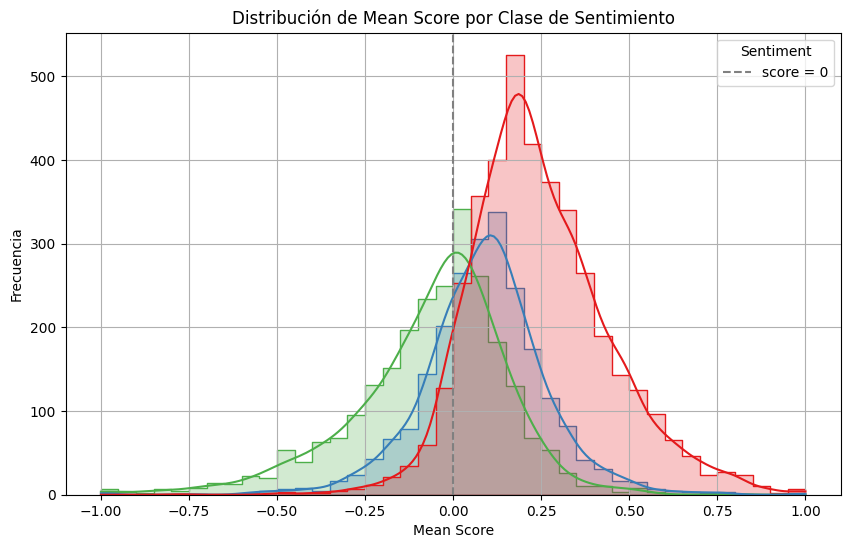

In [8]:
# Crear figura
plt.figure(figsize=(10, 6))

# Histograma con KDE por clase
sns.histplot(
    data=df,
    x="mean_score",
    hue="sentiment",           # Colorear por clase
    kde=True,                  # Línea de densidad
    bins=40,
    palette="Set1",
    element="step",           # Tipo de barras
    common_norm=False         # Normaliza cada clase por separado
)

# Añadir línea vertical en 0 como referencia
plt.axvline(x=0, color='gray', linestyle='--', label='score = 0')

# Etiquetas y título
plt.title("Distribución de Mean Score por Clase de Sentimiento")
plt.xlabel("Mean Score")
plt.ylabel("Frecuencia")
plt.legend(title='Sentiment')
plt.grid(True)

# Mostrar gráfico
plt.show()


In [9]:
# Aplicar filtrado con condiciones personalizadas por clase
df_filtrado = df[
    ((df['sentiment'] == 'POS') & (df['mean_score'] >= 0.1)) |
    ((df['sentiment'] == 'NEG') & (df['mean_score'] <= -0.1)) |
    ((df['sentiment'] == 'NEU') & (df['mean_score'] > -0.3) & (df['mean_score'] < 0.3))
]

In [10]:
df_filtrado.head()

,Unnamed: 0,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage,mean_score
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,absolutely brilliant film character deep plot ...,absolutely brilliant film characters deep plot...,POS,16.875000,0.456250
1,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,feel emotion long time chiron manifest emotion...,felt emotion long time chiron manifested emoti...,POS,12.867647,0.180000
2,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",movie masterpiece deserve oscar,movie masterpiece deserves oscars,POS,10.294118,0.250000
4,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",decent movie story so scoring great visual d...,decent movie story so scoring great visual d...,POS,13.131313,0.304167
5,8,Moonlight 2016,shumat,"Feb 3, 2023",8,very good film i fully reccomend it for everyb...,good film fully reccomend everybody like actio...,good film fully reccomend everybody likes acti...,POS,11.650485,0.536667


In [11]:
df_filtrado['sentiment'].value_counts()

sentiment
POS    3092
NEU    1999
NEG     899
Name: count, dtype: int64

In [12]:
# Separar para clasificación de sentimiento
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    df_filtrado['review'], df_filtrado['sentiment'], test_size=0.2, random_state=42)

In [13]:
# Separar para clasificación
X_train_no_lem3, X_test_no_lem3, y_train_no_lem3, y_test_no_lem3 = train_test_split(
    df_filtrado['review_no_lem'], df_filtrado['sentiment'], test_size=0.2, random_state=42)

### TF-IDF + LR

In [ ]:
#tfidf = TfidfVectorizer(max_features=1500)
X_train_vec3 = tfidf.fit_transform(X_train3)
X_test_vec3 = tfidf.transform(X_test3)

In [ ]:
#le = LabelEncoder()
y_train_enc3 = le.fit_transform(y_train3)
y_test_enc3 = le.transform(y_test3)

modelLR = LogisticRegression(solver='liblinear')
modelLR.fit(X_train_vec3, y_train_enc3)
prediccion3 = modelLR.predict(X_test_vec3)


print(classification_report(y_test_enc3, prediccion3, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.90      0.69      0.78       172
         NEU       0.75      0.69      0.72       378
         POS       0.83      0.92      0.87       648

    accuracy                           0.81      1198
   macro avg       0.83      0.77      0.79      1198
weighted avg       0.81      0.81      0.81      1198



### BERT + LR

In [22]:
# Aplicar BERT a tus textos de test
X_train_bert3 = model_bert.encode(X_train_no_lem3.tolist(), convert_to_numpy=True)
X_test_bert3 = model_bert.encode(X_test_no_lem3.tolist(), convert_to_numpy=True)

In [23]:
le = LabelEncoder()
y_train_enc3 = le.fit_transform(y_train_no_lem3)
y_test_enc3 = le.transform(y_test_no_lem3)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_bert3, y_train_enc3)
prediccion3_bert = modelLR.predict(X_test_bert3)


print(classification_report(y_test_enc3, prediccion3_bert, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.84      0.71      0.77       172
         NEU       0.68      0.63      0.65       378
         POS       0.82      0.89      0.86       648

    accuracy                           0.78      1198
   macro avg       0.78      0.74      0.76      1198
weighted avg       0.78      0.78      0.78      1198



## Modelos de regresión

#### TF-IDF + LR

In [35]:
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review_lem'], df['score'], test_size=0.2, random_state=42)

In [36]:
X_train_score_vec = tfidf.fit_transform(X_train_score)
X_test_score_vec = tfidf.transform(X_test_score)

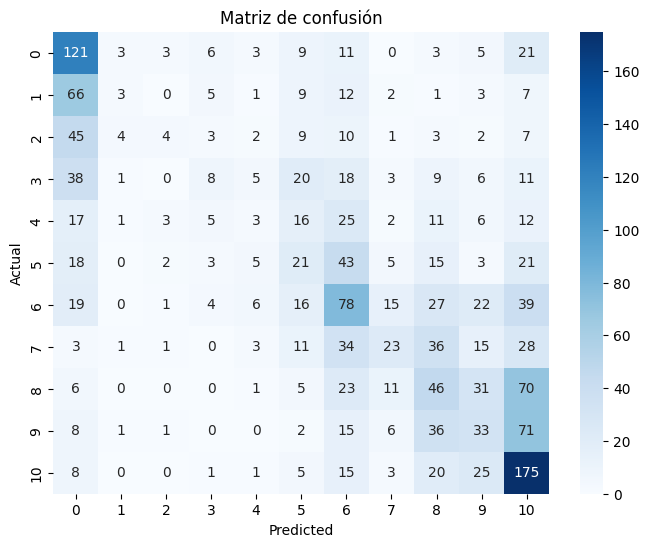

              precision    recall  f1-score   support

           0       0.35      0.65      0.45       185
           1       0.21      0.03      0.05       109
           2       0.27      0.04      0.08        90
           3       0.23      0.07      0.10       119
           4       0.10      0.03      0.05       101
           5       0.17      0.15      0.16       136
           6       0.27      0.34      0.31       227
           7       0.32      0.15      0.20       155
           8       0.22      0.24      0.23       193
           9       0.22      0.19      0.20       173
          10       0.38      0.69      0.49       253

    accuracy                           0.30      1741
   macro avg       0.25      0.24      0.21      1741
weighted avg       0.26      0.30      0.25      1741



In [38]:
le = LabelEncoder()
y_train_score_enc = le.fit_transform(y_train_score)
y_test_score_enc = le.transform(y_test_score)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_score_vec, y_train_score_enc)
prediccion = modelLR.predict(X_test_score_vec)


# Calcular la matriz de confusión
cm = confusion_matrix(y_test_score_enc, prediccion)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
print(classification_report(y_test_score_enc, prediccion, target_names=[str(c) for c in le.classes_]))


#### BERT + LR

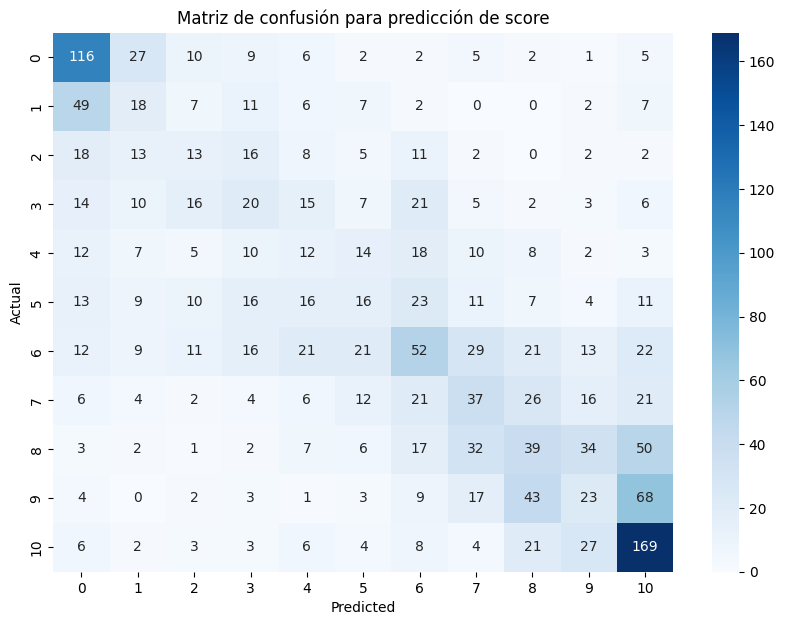

              precision    recall  f1-score   support

           0       0.46      0.63      0.53       185
           1       0.18      0.17      0.17       109
           2       0.16      0.14      0.15        90
           3       0.18      0.17      0.17       119
           4       0.12      0.12      0.12       101
           5       0.16      0.12      0.14       136
           6       0.28      0.23      0.25       227
           7       0.24      0.24      0.24       155
           8       0.23      0.20      0.22       193
           9       0.18      0.13      0.15       173
          10       0.46      0.67      0.55       253

    accuracy                           0.30      1741
   macro avg       0.24      0.26      0.24      1741
weighted avg       0.27      0.30      0.28      1741



In [48]:
# 1. Separar los datos
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review_no_lem'], df['score'], test_size=0.2, random_state=42
)

# 2. Codificar las etiquetas
le = LabelEncoder()
y_train_score_enc = le.fit_transform(y_train_score)
y_test_score_enc = le.transform(y_test_score)

# 4. Obtener embeddings BERT
X_train_bert = model_bert.encode(X_train_score.tolist(), convert_to_numpy=True)
X_test_bert = model_bert.encode(X_test_score.tolist(), convert_to_numpy=True)

# 5. Entrenar modelo
clf = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
clf.fit(X_train_bert, y_train_score_enc)

# 6. Predecir
y_pred = clf.predict(X_test_bert)

# 7. Matriz de confusión
cm = confusion_matrix(y_test_score_enc, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusión para predicción de score')
plt.show()

# 8. Reporte de clasificación
print(classification_report(y_test_score_enc, y_pred, target_names=le.classes_.astype(str)))


## Recomendador

Vamos a hacer un recomendador de películas para uno de los usuarios que han escrito sus reseñas en la página web. La idea del recomendador es basarse en el género de las películas que más le han gustado al usuario, lo cual vendrá determinado por la puntuación de la reseña (score).

El principal problema al que nos enfrentamos es que nuestro dataset de reseñas no incluye el género de las películas. Para poder incluirlo, descargamos un dataset de kaggle que contiene muchas películas de meta-critic y su género, entre otras características.

In [9]:
movies_df = pd.read_csv("data/16k_Movies.csv")
movies_df.head()

,Unnamed: 0,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,0,Dekalog (1988),"Mar 22, 1996",This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,1,Three Colors: Red,"Nov 23, 1994",Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,"Drama,Mystery,Romance"
2,2,The Conformist,"Oct 22, 1970","Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,"Alberto Moravia, Bernardo Bertolucci",1 h 47 m,Drama
3,3,Tokyo Story,"Mar 13, 1972",Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,"Kôgo Noda, Yasujirô Ozu",2 h 16 m,Drama
4,4,The Leopard (re-release),"Aug 13, 2004","Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,"Giuseppe Tomasi di Lampedusa, Suso Cecchi D'Am...",3 h 7 m,"Drama,History"


Una vez cargado el dataset, le modificamos la estructura para que tenga por columnas todos los géneros posibles y por filas las películas, de forma que cada película tenga un 1 en una columna si la película pertenece a un género y un 0 en otro caso.

In [10]:
movies_df['Genres'] = movies_df.Genres.str.split(',')

# Copiar el dataframe
moviesWithGenres_df = movies_df.copy()

# Reemplazar NaN por listas vacías para poder iterar
moviesWithGenres_df['Genres'] = moviesWithGenres_df['Genres'].apply(lambda x: x if isinstance(x, list) else [])

# Crear columnas dummy por género
for index, row in moviesWithGenres_df.iterrows():
    for genre in row['Genres']:
        genre = genre.strip()
        if genre:
            moviesWithGenres_df.at[index, genre] = 1

# Rellenar NaNs con 0
moviesWithGenres_df = moviesWithGenres_df.fillna(0)

# Si no quieres quedarte con la columna 'Title' duplicada, puedes eliminarla
moviesWithGenres_df.drop(columns=['Unnamed: 0', 'Description', 'No of Persons Voted', 'Rating', 'Directed by', 'Written by', 'Duration'], inplace=True)

# Ver resultados
moviesWithGenres_df.head()

,Title,Release Date,Genres,Drama,Mystery,Romance,History,Crime,Adventure,Biography,...,Music,Horror,News,Musical,Western,Unknown,Game-Show,Film-Noir,Talk-Show,Reality-TV
0,Dekalog (1988),"Mar 22, 1996",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Three Colors: Red,"Nov 23, 1994","[Drama, Mystery, Romance]",1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Conformist,"Oct 22, 1970",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Tokyo Story,"Mar 13, 1972",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Leopard (re-release),"Aug 13, 2004","[Drama, History]",1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Vemos si hay usuarios que han comentado más de una vez.

In [11]:
# Ver cuántas veces aparece cada username
df['username'].value_counts()

username
JLuis_001         87
TVJerry           72
Brent_Marchant    70
LeZee             57
EpicLadySponge    51
                  ..
Stephchan1901      1
wordy_actions      1
carlj12345         1
princefan1999      1
sugarnite          1
Name: count, Length: 4888, dtype: int64

A continuación, filtramos para quedarnos con los usuarios que tengan mínimo 10 reseñas y escogemos uno aleatoriamente.

In [13]:
# Contar las reseñas por usuario
user_counts = df['username'].value_counts()

# Filtrar los usuarios con exactamente 5 reseñas
users_with_10_reviews = user_counts[user_counts >= 10].index

# Elegir uno aleatoriamente
import random
random_user = random.choice(users_with_10_reviews.tolist())

# Mostrar las 5 reseñas de ese usuario
df[df['username'] == random_user].head()

,Unnamed: 0,movie,username,date,score,review,review_lem,review_no_lem,sentiment,stopword_percentage
119,148,Roma,Compi24,"Jan 31, 2019",8,The kind of stick-to-your-ribs filmmaking with...,kind stick rib filmmaking potential kind movie...,kind stick ribs filmmaking potential kind movi...,POS,13.435701
517,615,Marriage Story,Compi24,"Jan 25, 2020",9,Yet another movie featuring a filmmaker baring...,movie feature filmmaker bare soul audience cel...,movie featuring filmmaker baring soul audience...,POS,12.930375
846,996,Run All Night,Compi24,"Mar 13, 2015",8,In what might be Liam Neeson's finest action v...,liam neeson fine action vehicle take jaume col...,liam neeson finest action vehicle taken jaume ...,POS,13.389121
1152,1374,The Hitmans Bodyguard,Compi24,"Sep 2, 2017",7,"No, ""The Hitman's Bodyguard"" doesn't break any...",hitman bodyguard break new ground like whatsoe...,hitman bodyguard break new ground like whatsoe...,POS,9.317804
2966,3462,Geostorm,Compi24,"Nov 21, 2019",3,An honest-to-God chore to watch from start to ...,honest god chore watch start finish geostorm b...,honest god chore watch start finish geostorm b...,NEG,11.179361


Filtramos para quedarnos solo con las películas que ha visto el ususario y su puntuación.

In [14]:
inputMovies = df[df['username'] == random_user][['movie', 'score']]
inputMovies

,movie,score
119,Roma,8
517,Marriage Story,9
846,Run All Night,8
1152,The Hitmans Bodyguard,7
2966,Geostorm,3
3061,Replicas 2018,3
3141,Spotlight,9
3370,Little Women 2019,8
3444,The Favourite,9
3558,Phantom Thread,9


Ahora filtramos el dataframe que contiene todas las películas con sus géneros para quedarnos solo con las que ha visto el usuario.

In [16]:
#Descartando las películas de la entrada de datos
userMovies = moviesWithGenres_df[moviesWithGenres_df['Title'].isin(inputMovies['movie'].tolist())]
userMovies.head()

,Title,Release Date,Genres,Drama,Mystery,Romance,History,Crime,Adventure,Biography,...,Music,Horror,News,Musical,Western,Unknown,Game-Show,Film-Noir,Talk-Show,Reality-TV
26,Roma,"Nov 21, 2018",[Drama],1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Marriage Story,"Nov 6, 2019","[Drama, Romance]",1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,Spotlight,"Nov 6, 2015","[Biography, Crime, Drama]",1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,The Favourite,"Nov 23, 2018","[Biography, Comedy, Drama, History]",1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259,Phantom Thread,"Dec 25, 2017","[Drama, Romance]",1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Claramente nos hemos quedado con menos películas (hemos pasado de 10 a 6), porque no todas las películas del dataset de las reseñas están en el dataset importado de Kaggle.

In [17]:
inputMovies = inputMovies[inputMovies['movie'].isin(userMovies['Title'])]
inputMovies = inputMovies.reset_index(drop=True)
inputMovies

,movie,score
0,Roma,8
1,Marriage Story,9
2,Run All Night,8
3,Geostorm,3
4,Spotlight,9
5,The Favourite,9
6,Phantom Thread,9
7,Brooklyn,7
8,If Beale Street Could Talk,7
9,The Farewell,6


In [20]:
#Inicializando el índice para evitar problemas a futuro
userMovies = userMovies.reset_index(drop=True)

#Eliminando problemas innecesarios para ahorrar memoria y evitar conflictos
userGenreTable = userMovies.drop(columns=['Title', 'Release Date', 'Genres'])


Sacamos los géneros que más le gustan al usuario:

In [21]:
#Producto escalar para obtener los pesos
userProfile = userGenreTable.transpose().dot(inputMovies['score'])
#Perfil del usuario
userProfile

Drama          111.0
Mystery         15.0
Romance         54.0
History          3.0
Crime           21.0
Adventure        9.0
Biography       11.0
War              0.0
Comedy          24.0
Thriller        34.0
Fantasy         15.0
Documentary      0.0
Sport            0.0
Sci-Fi           6.0
Action          12.0
Animation        0.0
Family           0.0
Music            0.0
Horror           7.0
News             0.0
Musical          0.0
Western          0.0
Unknown          0.0
Game-Show        0.0
Film-Noir        0.0
Talk-Show        0.0
Reality-TV       0.0
dtype: float64

In [22]:
#Ahora llevemos los géneros de cada película al dataframe original
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['Title'])
#Y eliminemos información innecesaria
genreTable = genreTable.drop(columns=['Title', 'Release Date', 'Genres'])


Obtenemos una puntuación para todas las películas del dataset basada en el género de las películas que más le han gustado al ususario.

In [23]:
#Multiplicando los géneros por los pesos para luego calcular el peso promedio
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df

Title
Dekalog (1988)                             0.344720
Three Colors: Red                          0.559006
The Conformist                             0.344720
Tokyo Story                                0.344720
The Leopard (re-release)                   0.354037
                                             ...   
Boys to Men                                0.344720
Saint Misbehavin': The Wavy Gravy Movie    0.000000
Collectors                                 0.000000
Bonhoeffer                                 0.043478
7th Street                                 0.000000
Length: 16290, dtype: float64

Sacamos el TOP 5 de películas con mayor puntuación (mayor porbabilidad de que le gusten al usuario) y las imprimimos por pantalla.

In [24]:
# Asegúrate de que la columna 'Title' de movies_df no tenga duplicados
movies_unique = movies_df.drop_duplicates(subset='Title')

# Seleccionar las 5 películas más recomendadas y convertir a DataFrame
top_recommendations = recommendationTable_df.head(5).to_frame(name='score')

# Unir con los géneros usando el índice (que es el título de la película)
top_recommendations = top_recommendations.merge(
    movies_unique[['Title', 'Genres']],
    left_index=True,
    right_on='Title'
)

# Reordenar columnas y ordenar por score descendente
top_recommendations = top_recommendations[['Title', 'score', 'Genres']].sort_values(by='score', ascending=False)

# Mostrar resultado final
top_recommendations

,Title,score,Genres
1,Three Colors: Red,0.559006,"[Drama, Mystery, Romance]"
4,The Leopard (re-release),0.354037,"[Drama, History]"
0,Dekalog (1988),0.344720,[Drama]
2,The Conformist,0.344720,[Drama]
3,Tokyo Story,0.344720,[Drama]
